# Warm-Up: Monte Carlo Integration

### Exercise 1

Write a program to evaluate
$$I = \int_0^2 \sin^2\left[\frac1{(2-x)x}\right]\text d x$$
using the "hit-or-miss" method with $N= 10^4$ points.

Also evaluate the error on your method.

In [3]:
import numpy as np 


def f(x):
    return (np.sin(1/(x*(2-x))))**2

N = 10**4
area = 2

frac = 0
for k in range(N):      #loop over this k times 
    x_num = 2*np.random.random()     #random number along x and y 
    y_num = np.random.random()
    if y_num < f(x_num):    #check if the random point lies above or below curve 
        frac += 1     #if below, up the fraction of points 


I = area*frac/N

print(I)



1.4492


### Exercise 2

Write a program to evaluate
$$I = \int_0^2 \sin^2\left[\frac1{(2-x)x}\right]\text d x$$
using the mean value method with $N = 10^4$ points.

Also evaluate the error on your method.

In [4]:
#set initial conditions on sum and bounds 
f_sum = 0
a = 0
b = 2

for k in range(N):  #loop over 10**4 times 
    x_num = 2*np.random.random() #random x value 
    f_sum = f_sum + f(x_num)    #add the value to the sum 

I = ((b-a)/N) * f_sum   #estimate the integral 

print(I)   

1.4531514204951925


# Monte Carlo for Statistical Mechanics

## StatMech review

If I was your prof for PHY252, this seems familiar... right?

* For a system in equilibrium at temperature $T$, the probability of finding the system in any particular state $i$ is given by the Boltzmann distribution,
$$P(E_i) = \frac{\exp\left[-E_i/(k_B T)\right]}{Z}, \quad Z = \sum_{i=1}^{ALL}\exp\left[-E_i/(k_B T)\right]$$
where $E_i$ is the energy of state $i$, $k_B$ is Boltzmann's constant, $Z$ is partition function

* System at temperature $T$ undergoes transitions between states, with probability of being in a particular state $P(E_i)$ 

* To calculate expectation value of a macroscopic property $X$ (e.g. total energy, magnetization, spin): average over the many microstates that the system visits
    $$\left<X\right> = \sum_{i=1}^{ALL}X_i P(E_i)$$
    where $X_i$ is the value of the quantity in the $i^\text{th}$ microstate and $P$ is the probability of finding the system in that microstate. 

### Computational Issues

* Simple example: single mole of gas has $N_A \approx 6\times 10^{23}$ molecules.
    Assume each molecule had only 2 possible spin states (gross underestimation), then the total number of spin microstates of the mole of gas is $2^{N_A}$, which is huge.
* If we want to get any  useful macroscopic information $\left<X\right>$ about the system, we need to be more clever about how we count than just brute-force counting everything.

$$\left<X\right> = \sum_{i=1}^{ALL}X_i P(E_i), \quad P(E_i) = \frac{\exp\left[-E_i/(k_B T)\right]}{Z}, \quad Z = \sum_{i=1}^{ALL}\exp\left[-E_i/(k_B T)\right]$$


* Huge number of terms in sum $\Rightarrow$ often impossible to perform analytically $\Rightarrow$ use Monte Carlo summation.
* Two difficulties to overcome:
    1. estimating $\left<X\right>$: properly sampling which terms to sum over (*solution: importance sampling*),
    2. estimating $Z$ (*solution: Markov Chain Monte Carlo*)
    

## Importance sampling for Stat. Mech.

* Randomly sample the terms in the sum and only use those as an estimate. Replace
   $\left<X\right> = \sum_{i=1}^{ALL}X_i P(E_i)$
    with a sum over $N$ randomly sampled microstates,
    $$\left<X\right> = \frac{\sum_{i=1}^{N}X_i P(E_i)}{\sum_{i=1}^{N}P(E_i)}.$$
  * Denominator ensures total probability over the sampled states is 1.
* To get a good estimate for the sum, it is only worth keeping the big terms
  * A lot of states have $E_ i \gg k_B T$, therefore $P(E_i)$ really small since probability is proportional to $\exp\left[-E_i/(k_B T)\right]$
* Need to preferentially choose terms where the integrand is non-negligible, but assign them less weight individually (to not bias the final estimate) ... so use importance sampling!



* For a dicrete sum (see p. 478),
    $$\left<X\right> = \sum_{i=1}^{N}X_i P(E_i) \approx \frac1N \sum_{k=1}^{N}\frac{X_k P(E_k)}{w_k} \sum_{i=1}^{ALL}w_i.$$
* For weight $w$, use $P(E_i)$
$$\left<X\right> \approx \frac1N \sum_{k=1}^{N}\underbrace{\frac{X_k P(E_k)}{P(E_k)}}_{= X_k} \underbrace{\sum_{i=1}^{ALL}P(E_i)}_{=1}.$$

In the end,
$$\left<X\right> \approx \frac1N \sum_{k=1}^{N} X_k.$$
* Looks simple and no different from mean-value MC,
* but recall that the $X_k$'s are drawn from non-uniform distribution: we randomly choose terms in the sum based on their Boltzmann probabilities, $P(E)$. But how? Recall
    $$P(E_i) = \frac{\exp\left[-E_i/(k_B T)\right]}{Z}, \quad Z = \sum_{i=1}^{ALL}\exp\left[-E_i/(k_B T)\right]$$

* To do it this way, we need $Z$, which is a sum over all states. But if we could do this, we wouldn't need Monte Carlo in the first place!

## Markov chain method

Mish-mashing https://en.wikipedia.org/wiki/Markov_chain and https://en.wikipedia.org/wiki/Markov_property,

> A Markov chain is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. [...] (sometimes characterized as "memorylessness"). In simpler terms, it is a process for which predictions can be made regarding future outcomes based solely on its present state [...]. In other words, conditional on the present state of the system, its future and past states are independent.

* Random walks (Brownian motion) are Markov chains.
* Here: events are jumps in energy states, one after another.

* Text goes into details on how to implement the Markov Chain method with a Metropolis algorithm.
* Crucial key: Metropolis does not directly compute probability to be in one state, but instead uses probability to transition between two states
   * $Z$ cancels out in the process!
* In this lab, we will summarize it algorithmically first, then briefly outline why it works mathematically.

### Algorithm

1. Choose a random starting state $i$
2. Calculate the energy of that state $E_i$
3. Choose a transition to a new state $j$ uniformly at random from allowed set
4. Calculate the energy of this new state, $E_j$
5. Calculate the acceptance probability for this transition:
    * $P_a = 1\qquad\qquad \qquad \quad \text{if}\ E_j \leq E_i$ (always accept a lower energy state)
    * $\displaystyle P_a = \exp\left(-\frac{E_j - E_i}{k_B T}\right) \quad \text{if}\ E_j > E_i$ (accept a higher energy state sometimes, more often for high $T$).
6. Accept/reject the move according to the acceptance probability
7. Measure the quantity $X$ you want in its current state (new or old $i$) & store it
8. Repeat from step 2.


Why does Metropolis create a system where each microstate has a probability $P(E_i)$, the Boltzmann distribution?
* Let $\tau_{ij}$ be transition probability from microstate $i$ to microstate $j$, such that
    $$\frac{\tau_{ij}}{\tau_{ji}} = \frac{P(E_j)}{P(E_i)},$$
    which the Metropolis algorithm satisfies (see p. 482). For example, a small ratio above means 
    * RHS: "*$j$ is much less probable than $i$*" and equivalently,
    * LHS: "*probability of $j\to i$ is much higher than $i\to j$*", 
  
    both statements being true in equal amounts.
* "In equal amounts" is crucial: it means that if you start from any initial state, your system will progressively evolve towards one where all microstates follow Boltzmann.
* Does it always converge? Yes. If you love linear algebra, see proof in Appendix D of Newman (it is actually quite elegant).

### Exercise 3

Write code to implement steps 5-6 of the algorithm. It should be in the form of a function that takes energies and temperature as arguments, and returns something representing true or false (accept or reject). Hints:

* Simplify the problem by setting $k_B = 1$.
* For the probability of the event:
    * $P_a = 1\qquad\qquad \qquad \quad \text{if}\ E_j \leq E_i$ (always accept a lower energy state)
    * $\displaystyle P_a = \exp\left(-\frac{E_j - E_i}{k_B T}\right) \quad \text{if}\ E_j > E_i$ (sometimes accept a higher energy state, more often for higher $T$).

* Draw a random number in $[0,1)$ and compare it to $P_a$`
    * E.g., at very high $T$, $\exp(\dots) \approx 1$ and almost all moves are accepted.
    * E.g., at low $T$, say, $\exp[-\Delta E/(k_BT)] = 1\%$, then `random()` has 1% chance of drawing a number that is $<1\%$.
    * If $E_j \leq E_i$, then $\exp(\dots) \geq 1$ and your function should automatically accept.

In [12]:
def transitionProbability(Ei, Ej, T) -> bool:
        #calculate the probabilities of transition

    if Ej <= Ei:    
        P_a = 1

    if Ej > Ei:
        P_a = np.exp(-(Ej - Ei)/T)

        #pull a random number to compare it to 
    compare_rand = np.random.random()   

    # print(P_a, compare_rand)

        #if P_a is small, low transition probability, most likely rejected 
    if P_a < compare_rand:
        return False 
    
        #if P_a is near 1, high transition probability for high T, most likely accepted
    if P_a >= compare_rand:
        return True 
    
    


## Ising model

* Simple model of ferromagnetism, demonstrating many physical characteristics of fancier models.
* Assume an object is made up of a collection of dipoles (e.g., electron spins) and the net magnetization is the sum of the magnetization of all the spins.
    * the spins can only point up or down.
    * the spins interact and favour parallel alignment of pairs of spins
    * the interactions are non-zero only between nearest neighbours (i.e., distance dependent).
* Macroscopic energy $E$ and magnetization $M$ (with no external field) are given by 
    $$E = -J\sum_{\left<ij\right>} s_i s_j\quad\text{and}\quad M = \sum_{i}s_i$$
    where $s = +1$ if spin is up & $s = -1$ if spin is down.
    * Lowest energy occurs if the spins all line up.

* Spins can randomly flip as the system visits a set of allowable states given its temperature.  At any particular moment the system may look like:

![Ising](Ising2D.png)

### Exercise 4

For the 1-dimensional Ising model, with $N$ dipoles, write code to: create an array representing the dipole spins, and initialize the state of the system such that there's random spin at each location. (The code should take $N$ as an argument, and return the initialized array).

Then, write a function to calculate the energy and magnetization (these should be the return values) for a given array of dipoles (this should be the argument). Use $J = 1$ milliJoule.

In [6]:
def ising_init(N):
    dipoles = np.zeros(N, float)

    spin_up = -1
    spin_down = 1

    for k in range(N):
        rand_val = np.random.randint(0, 2)

        if rand_val == 1:
            dipoles[k] = spin_down

        elif rand_val == 0:
            dipoles[k] = spin_up

    return dipoles



def get_energy(dipoles):
    J = 1
    spins = 0
    N = len(dipoles)
    for i in range(N-1):
        spins += dipoles[i] * dipoles[i+1]

    return -J*spins
            


def get_magnetization(dipoles):
    return np.sum(dipoles)


# array = ising_init(10)
# E = get_energy(array)
# M = get_magnetization(array)
# print(E, M)

### Exercise 5

Implement the Metropolis algorithm to model the behaviour of the array of dipoles.
* create new state: flip 1 spin randomly 
* calculate new total energy
* calculate acceptance probability
* decide whether to accept or reject new state
* store 'new' energy & magnetization
* repeat $M$ times

Your function should keep track of energy and magnetization throughout. Return an array representing the energy at each flip attempt, and another array representing the magnetization at each flip attempt.

Use your code from the previous 2 exercises to help. You should have $T$ and $M$ as parameters that can be easily set.

In [17]:
def ising_newstate(dipoles):
    N = len(dipoles)
    k = np.random.randint(0, N)   #get a random index between 0 and N

    dipoles[k] = (-1)*dipoles[k]    #flip the spin of that random index 

    return dipoles



def ising_evolve(dipoles, M, T):
    energy_hist = []        #create array of all recorded energy entries
    magnet_hist = []        #and magnetizations

    config = dipoles
    counter = 0
    
    while counter < M:  #loop M times 
        E_init = get_energy(config)        #get energy of current state
        M_init = get_magnetization(config) #get magnetization of current state 

        energy_hist.append(E_init)  #append the energy and magnetization values to the history arrays 
        magnet_hist.append(M_init)

        new_config = ising_newstate(config)     #flip a spin 
        E_new = get_energy(new_config)       #get energy of new state 

        if transitionProbability(E_init, E_new, T) == True: 
            #if the transition is allowed, set the current state to the new state and repeat 
            config = new_config
            # print('flipped!')


        else:
            config = config
            # print('no flip!')

        counter += 1

    return energy_hist, magnet_hist      #return histories of E and M entries 




### Exercise 6

Using your code from the previous exercise, plot energy and magnetization as a function of time (assuming 1 flipping attempt per millisecond) for $N=100,M=100000$, for each of 3 different temperatures: $T=0.1,1.0,10.0$

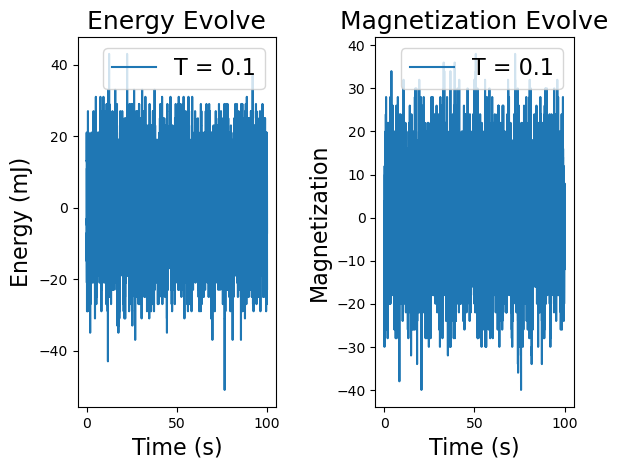

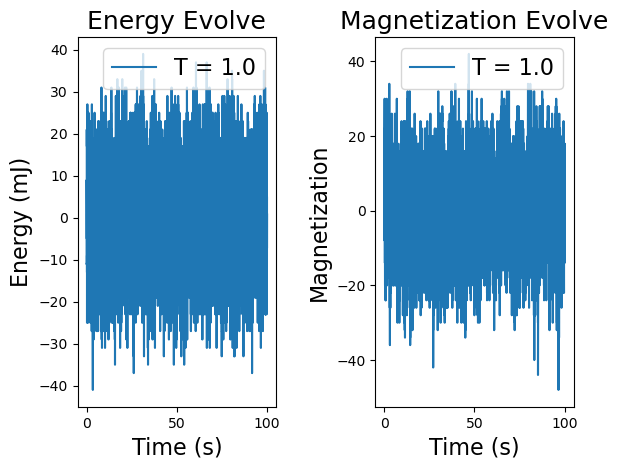

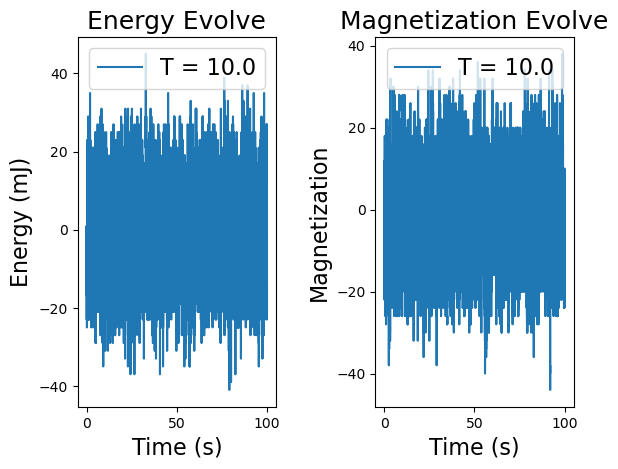

In [18]:
import matplotlib.pyplot as plt 

N = 100
M = 100000
T_range = (0.1, 1, 10)
time = np.linspace(0, 100, M)

ising_array = ising_init(N)



for T in T_range:
    e_vals, mag_vals = ising_evolve(ising_array, M, T)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplots_adjust(wspace = 0.5)

    ax1.plot(time, e_vals, label='T = %.1f'%T)
    ax1.set_xlabel('Time (s)', fontsize=16)
    ax1.set_ylabel('Energy (mJ)', fontsize=16)
    ax1.set_title('Energy Evolve', fontsize=18)
    ax1.legend(loc='upper right', fontsize=16)

    ax2.plot(time, mag_vals, label='T = %.1f'%T)
    ax2.set_xlabel('Time (s)', fontsize=16)
    ax2.set_ylabel('Magnetization', fontsize=16)
    ax2.set_title('Magnetization Evolve', fontsize=18)
    ax2.legend(loc='upper right', fontsize=16)

plt.show()


#should expect the energy and magnetization to converge to a specific value for lower T, 
#and for some reason I don't understand why I'm not seeing that. All of my code & functions seem correct 

